<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/chmntz_Lab4/Lab4/chmntz_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Integration**
Carl **Chemnitz**

# **Abstract**
This lab is about numerical intergration, *quadrature*, an important field of computational mathematics. This lab discusses and implements the Gauss quadrature rule and Monte Carlo integration.

# **Set up environment**
To have access to the neccessary modules you have to run this cell.

In [1]:
from google.colab import files

import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

from typing import Callable
from sympy import integrate, Symbol

X = Symbol('x')
Y = Symbol('y')

# **Introduction**

Integration is an important field of calculus and often describes some density over an interval. In numerical analysis *quadratures* is the numerical approximation of integrals. All numerical methods that approximates an integral follows the *quadrature rule*,
\begin{equation}
    \int_{a}^{b}f(x)dx\approx\sum_{i=0}^{n}f(x_i)w_i,
    \tag{11.2}
\end{equation}
with $n+1$ quadrature points $x_i\in[a,b]$ and quadrature weights $w_i\in R$, as given in *Methods in Computational Science*, Theorem (11.2).

Gauss quadrature is a quadrature rule that gives exact results for polynomial integrals up to degree $2n+1$. Gauss quadrature rule defined on the interval $[-1,1]$.

Stochastic methods are methods that are based on random sampling. One such method is Monte Carlo intergration.

# **Method**

## 2-point Gauss quadrature over a unit interval
The 2-point Gauss rule on the interval $[-1,1]$ is defined as
$$\int_{-1}^{1}f(x)dx\approx f(x_0)w_0+f(x_1)w_1.$$
To integrate over an arbitrary interval $[a,b]$, we need to construct a map transformation function,
$$g:[a,b]\rightarrow[-1,1].$$
This gives us the function
$$\int_{a}^{b}f(x)dx\approx\frac{b-a}{2}\sum_{i=0}^{1}f(\frac{b-a}{2}x_i+\frac{a+b}{2})w_i,$$
for the interval $[a,b]$. Example 11.3 in *Methods in Computational Science*, the weights are given as $w_0=w_1=1$ and $x_0=1/\sqrt{3}$ and $x_1=-1/\sqrt{3}$. This gives that he 2-point quadrature over an interval $[a,b]$ is
$$\int_a^bf(x)dx\approx\frac{b-a}{2}\Big(f(\frac{b-a}{2}(\frac{1}{\sqrt{3}})+\frac{a+b}{2})+f(\frac{b-a}{2}(-\frac{1}{\sqrt{3}})+\frac{a+b}{2})\Big)$$

To avoid computing $1/\sqrt{3}$, the value was approximated instead, $1/\sqrt{3}=0.57735026919$.

In [2]:
def gauss_2_quad(f: Callable, a: float, b: float) -> float:
    # 1 / sqrt(3) ≈ 0.57735026919
    # w1 = w2 = 1
    wfx1 = f(0.5 * ((b - a) * (0.57735026919) + (b + a)))
    wfx2 = f(0.5 * ((b - a) * (-0.57735026919) + (b + a)))
    return 0.5 * (b - a) * (wfx1 + wfx2)

## 3-point edge midpoint quadrature over a reference triangle
3-point edge midpoint quadrature over a reference triangle is an 3-point Gauss quadrature with the weights $w_0=w_1=w_2=1/6$ and with the quadrature points $(x_i,y_i)$ at the midpoints of the edges of the reference triangle.
$$\int_{\triangle_r}f(x,y)dxdy\approx\sum_{i=0}^{2}f(x_i,y_i)w_i.$$
The reference triangle is defined as $\triangle_r=([1,0],[0,1],[0,0])$, thus it follows that the midpoints $(x_i,y_i)=\Big((\frac12,0),(0,\frac12),(\frac12,\frac12)\Big)$, which gives
$$\int_{\triangle_r}f(x,y)dxdy\approx \frac16f(\frac12,0)+\frac16f(0,\frac12)+\frac16f(\frac12,\frac12)=\frac16\Big(f(\frac12,0)+f(0,\frac12)+f(\frac12,\frac12)\Big)$$

In [3]:
def edge_midpoint_3_point(f: Callable) -> float:
    wfx1 = 0.16666666667 * f(0.5, 0.0)
    wfx2 = 0.16666666667 * f(0.0, 0.5)
    wfx3 = 0.16666666667 * f(0.5, 0.5)
    return wfx1 + wfx2 + wfx3

## Monte Carlo quadrature over a unit interval

Monte Carlo intergration is an randomized algorithm to approximate the integral
$$\int_Df(x)dx,$$
where $D$ is a subset of $R^d$. It approximates the integral by selecting random quadrature points and computing the mean. It is based on the *law of large numbers*, for large $n$, the mean approaches the expected value
$$g=\frac{1}{n}\sum_{i=1}^{n}f(x_i),\hspace{1em}E[g]=\frac{1}{|D|}\int_Df(x)dx.$$
Monte Carlo integration is defined as
$$\int_{D}f(x)dx\approx\frac{|D|}{n}\sum_{i=0}^{n}f(x_i)=\frac{1}{n}\sum_{i=0}^{n}f(x_i)|D|.$$

In [4]:
def monte_carlo_int(f: Callable, a: float, b: float, n: int = 10000) -> float:
    sum = 0
    for i in range(n):
        x_i = np.random.uniform(a, b)
        sum += f(x_i)
    return (b - a) / n * sum

## Monte Carlo quadrature over a reference triangle

To apply Monte Carlo integration over a reference triangle we need to construct an algorithm to sample random point on the triangle. In this lab, I implemented an algorithm described in [this paper](zhttps://www.cs.princeton.edu/~funk/tog02.pdf) (section 4.2). It gives a random sample point that is inside three given points that define a triangle.

In [5]:
def triangle_sampling(A: np.array, B: np.array, C: np.array) -> np.array:
    r = np.random.uniform(0, 1)
    s = np.random.uniform(0, 1)
    eps_a = 1.0 - np.sqrt(s)
    eps_b = (1.0 - r) * np.sqrt(s)
    eps_c = r * np.sqrt(s)
    x_i = eps_a * A[0] + eps_b * B[0] + eps_c * C[0]
    y_i = eps_a * A[1] + eps_b * B[1] + eps_c * C[1]
    return np.array([x_i, y_i])

When applying Monte Carlo integration over a reference triangle, the function is defined as
$$\int_{\triangle}f(x,y)dydx\approx\frac{\text{Area}(\triangle)}{n}\sum_{i=0}^{n}f(x_i,y_i),$$
as given in section 9 of [this paper](https://people.sc.fsu.edu/~jburkardt/presentations/cg_lab_monte_carlo_triangles.pdf).

In [6]:
def monte_carlo_int_triangle(f: Callable, A: np.array, B: np.array, C: np.array, n: int = 50000) -> float:
    sum = 0
    # a = np.sqrt((B[0] - C[0])**2 + (B[1] - C[1])**2)
    # b = np.sqrt((A[0] - C[0])**2 + (A[1] - C[1])**2)
    # c = np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)
    # s = (a + b + c) / 2
    # area = np.sqrt(s * (s - a) * (s - b) * (s - c)) # Herons formula
    area = 0.5
    for i in range(n):
        p = triangle_sampling(A, B, C)
        sum += f(p[0], p[1])
    return area * sum / n

# **Tests**

## 2-point Gauss quadrature over a unit interval
We define a random cubic polynomial $ax^3+bx^2+cx+d$.

In [7]:
c = np.random.randint(10, size=4)
f = lambda x : c[3]*x**3 + c[2]*x**2 + c[1]*x + c[0]

We compare the approximation from the implemented algorithm and the built-in `scipy.integrate.quad` to check if the implementation yields the expected result.

In [8]:
assert np.allclose(gauss_2_quad(f, 0, 1), sp.integrate.quad(f, 0, 1)[0])
print("'gauss_2_quad' was implemented successfully")

'gauss_2_quad' was implemented successfully


## 3-point edge midpoint quadrature over a reference triangle
We define a function
$$f(x,y)=ax^2+bx^2+cxy+dx+ey+g,$$
and integrate it, which yields
\begin{align*}
\int_{\triangle}f(x,y)dydx
& =\int_0^1\int_0^{1-x}f(x,y)dydx \\
& =\int_0^1\int_0^{1-x}ax^2+bx^2+cxy+dx+ey+g\hspace{0.5em}dydx
\end{align*}

In [9]:
c = np.random.randint(10, size=6)
f = lambda x, y : c[5]*x**2 + c[4]*y**2 + c[3]*x*y + c[2]*x + c[1]*y + c[0]

We check if the algorithm yields an approximation that approaches the exact solution.

In [10]:
exact = float(integrate(c[5]*X**2 + c[4]*Y**2 + c[3]*X*Y + c[2]*X + c[1]*Y + c[0], (Y, 0, 1-X), (X, 0, 1)))
assert np.allclose(edge_midpoint_3_point(f), exact)
print("'edge_midpoint_3_point' was implemented successfully")

'edge_midpoint_3_point' was implemented successfully


## Monte-Carlo quadrature over a unit interval
We create random polynomial $f(x)=ax^2+bx+c$.

In [11]:
c = np.random.randint(10, size=3)
f = lambda x : c[2]*x**2 + c[1]*x + c[0]
exact = sp.integrate.quad(f, 0, 1)[0]

We calculate the error $|\frac{|D|}{n}\sum_{i=0}^{n}f(x_i)-\int_{D}f(x)dx|$ for a range of quadrature points $n$ and then plot the error alongside the $1/\sqrt{n}$ to verify the convergance rate.

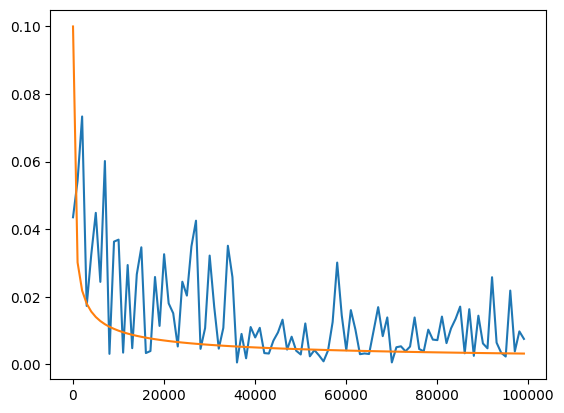

In [12]:
err = []
quad_points = range(100, 100100, 1000)
for n in quad_points:
    err.append(abs(monte_carlo_int(f, 0, 1, n) - exact))
plt.plot(quad_points, err)
plt.plot(quad_points, 1 / np.sqrt(quad_points))
plt.show()

## Monte Carlo quadrature over a reference triangle
We create random polynomial $f(x,y)=ax^2+bx^2+cxy+dx+ey+g$.

In [13]:
c = np.random.randint(10, size=6)
f = lambda x, y : c[5]*x**2 + c[4]*y**2 + c[3]*x*y + c[2]*x + c[1]*y + c[0]
exact = float(integrate(c[5]*X**2 + c[4]*Y**2 + c[3]*X*Y + c[2]*X + c[1]*Y + c[0], (Y, 0, 1-X), (X, 0, 1)))

We calculate the error $|\frac{\text{Area}(\triangle)}{n}\sum_{i=0}^{n}f(x_i,y_i)-\int_{D}f(x,y)dydx|$ for a range of quadrature points $n$ and then plot the error over quadrature points alongside the $1/\sqrt{n}$ to verify the convergance rate.
We use the previous exact solution that was calculated in previous test,
\begin{align*}
\int_{\triangle}f(x,y)dydx
& =\int_0^1\int_0^{1-x}f(x,y)dydx \\
& =\int_0^1\int_0^{1-x}ax^2+bx^2+cxy+dx+ey+g\hspace{0.5em}dydx
\end{align*}

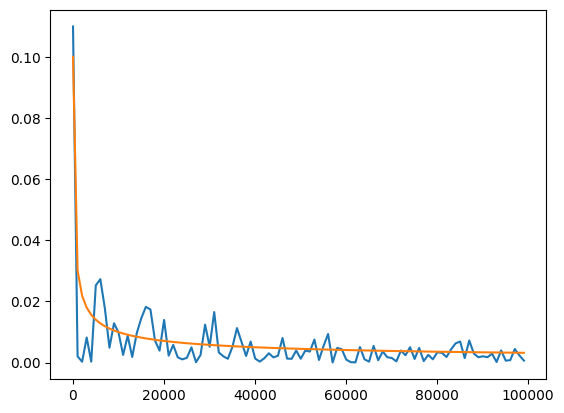

In [14]:
err = []
quad_points = range(100, 100100, 1000)
for n in quad_points:
    err.append(abs(monte_carlo_int_triangle(f, [1, 0], [0, 1], [0, 0], n) - exact))
plt.plot(quad_points, err)
plt.plot(quad_points, 1 / np.sqrt(quad_points))
plt.show()

# **Discussion**
The Gauss quadrature rule gives approximates that are very close
to exact solution, which is expected. However, the Monte Carlo algorithm was much less accurate than I expected. In this lab, I have difficulty to see the benefits that Stochastic methods are supposed to have when solving deterministic computational problems. However, they did follow the convergence rate. They could probably have benefitted majorly by implementing parallelization in the algorithm. This is possible as we are taking random point that are not dependant on any other point sampled previously. Although, a uniform distribution is still important.

Monte Carlo intergration requires uniform distributed random quadrature points $x_i$, thus `random.uniform` had to be used when implementing the algorithms.